In [57]:
import numpy as np
import pandas as pd
from matplotlib import ticker
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from burst_detection import extract_bursts
from matplotlib import pyplot as plt
import pandas as pd
import os.path as op
import mne
import scipy.io
import os
from mne.io import read_epochs_fieldtrip
from mne import create_info
import numpy as np
import mat73
import json

In [58]:
def many_is_in(substrings, string):
    return any(sub in string for sub in substrings)

In [59]:
file_path = 'bursts_three.json'
with open(file_path, 'r') as json_file:
        try:
            burst_three = json.load(json_file)
        except json.JSONDecodeError as e:
            raise ValueError(f"Error decoding JSON from file {file_path}: {e}")
    
print(burst_three[0].get("bursts", []))

{'trial': [0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12, 13, 13, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20], 'waveform': [[-7.539936478034612e-06, -7.101836353421924e-06, -6.413094778945454e-06, -5.58175487071884e-06, -4.750062719890342e-06, -4.065536015194345e-06, -3.6479992491238428e-06, -3.5632654318567763e-06, -3.8085241759263218e-06, -4.309559685668208e-06, -4.934254329922095e-06, -5.523596325306527e-06, -5.9272331501715275e-06, -6.032852380004389e-06, -5.7934987678392165e-06, -5.230986668269735e-06, -4.420956173346128e-06, -3.4822851865610847e-06, -2.5504506580858056e-06, -1.7425728839662813e-06, -1.134424298137433e-06, -7.49679268161162e-07, -5.615312729149629e-07, -5.05061632798333e-07, -4.938879579433335e-07, -4.391789209198737e-07, -2.665003473146431e-07, 7.329026850284795e-08, 6.02466907160933e-07, 1.3243655059697325e-06, 2.231759415196726

In [70]:
dict_output = {i: [] for i in burst_three[0].keys() if not many_is_in(["waveform", "waveform_times"], i)}
waveforms = []

for b in burst_three:
    [dict_output[k].append(b[k]) for k in dict_output.keys()];

for i in dict_output.keys():
    dict_output[i] = np.hstack(dict_output[i])

In [80]:
ict_output = {i: [] for i in burst_three[0].keys() if not many_is_in(["waveform", "waveform_times"], i)}
waveforms = []

for b in burst_three:
    # Append to dict_output for other keys
    [dict_output[k].append(b[k]) for k in dict_output.keys()]
    
    # Check if "waveform" exists before accessing it
    if "waveform" in b:
        waveforms.append(b["waveform"])
    else:
        print(f"'waveform' key not found in: {b}")  # Optional: Log missing "waveform" cases

# Handle the rest of dict_output and waveforms as before
for i in dict_output.keys():
    dict_output[i] = np.hstack(dict_output[i])

# Filter out empty or invalid waveforms
waveforms = np.vstack([i for i in waveforms if i.shape[0] > 0])

print("Processed waveforms:", waveforms)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



ValueError: need at least one array to concatenate

In [64]:
model = PCA(n_components=20)
scaler = RobustScaler().fit(waveforms[pca_subset])
model.fit(scaler.transform(waveforms[pca_subset]))
pc_scores = model.transform(waveforms) # all the bursts x 20 components 

ValueError: n_components=20 must be between 0 and min(n_samples, n_features)=1 with svd_solver='covariance_eigh'

In [71]:
waveforms = []

for entry in burst_three:
    bursts = entry.get('bursts', {})
    waveform_list = bursts.get('waveform', [])
    for sublist in waveform_list:
        for value in sublist:
            try:
                waveforms.append(float(value))  # Convertir 'value' en float et ajouter à la liste
            except ValueError:
                print(f"Invalid waveform value: {value}")

waveforms = np.array(waveforms)
waveforms = np.array(waveforms).reshape(-1, len(waveforms)//len(waveforms))
waveforms = np.vstack([i for i in waveforms if i.shape[0] > 0])

print("Extracted waveform:", waveforms)
print(waveforms.shape)

Extracted waveform: [[-7.53993648e-06]
 [-7.10183635e-06]
 [-6.41309478e-06]
 ...
 [ 8.58350749e-06]
 [ 8.55708541e-06]
 [ 8.86123778e-06]]
(635976, 1)


In [72]:
amp_max = np.max(waveforms, axis=1)
amp_map = (amp_max >= np.percentile(amp_max, 0.5)) & (amp_max <= np.percentile(amp_max, 99.5))
pca_subset = np.random.choice(np.arange(amp_max.shape[0])[amp_map], size=int(amp_max.shape[0]*0.5))
print("Shape of waveforms[pca_subset]:", waveforms[pca_subset].shape)

Shape of waveforms[pca_subset]: (317988, 1)


In [73]:
model = PCA(n_components=1)
scaler = RobustScaler().fit(waveforms[pca_subset])
model.fit(scaler.transform(waveforms[pca_subset]))
pc_scores = model.transform(waveforms) # all the bursts x 20 components 

In [74]:
for key, value in dict_output.items():
    print(f"Key: {key}, Length: {len(value)}")

Key: subject, Length: 66
Key: epoch, Length: 66
Key: bursts, Length: 66


In [75]:
pc_labels = ["PC_{}".format(i+1) for i in range(pc_scores.shape[1])]
pc_df = pd.DataFrame.from_dict({i: pc_scores[:,ix] for ix, i in enumerate(pc_labels)})
features_scores = pd.concat([pd.DataFrame.from_dict(dict_output), pc_df], axis=1)

np.save("waveforms.npy", waveforms)
features_scores.to_csv("burst_features_scores.csv", index=None)

NameError: name 'waveform_times' is not defined

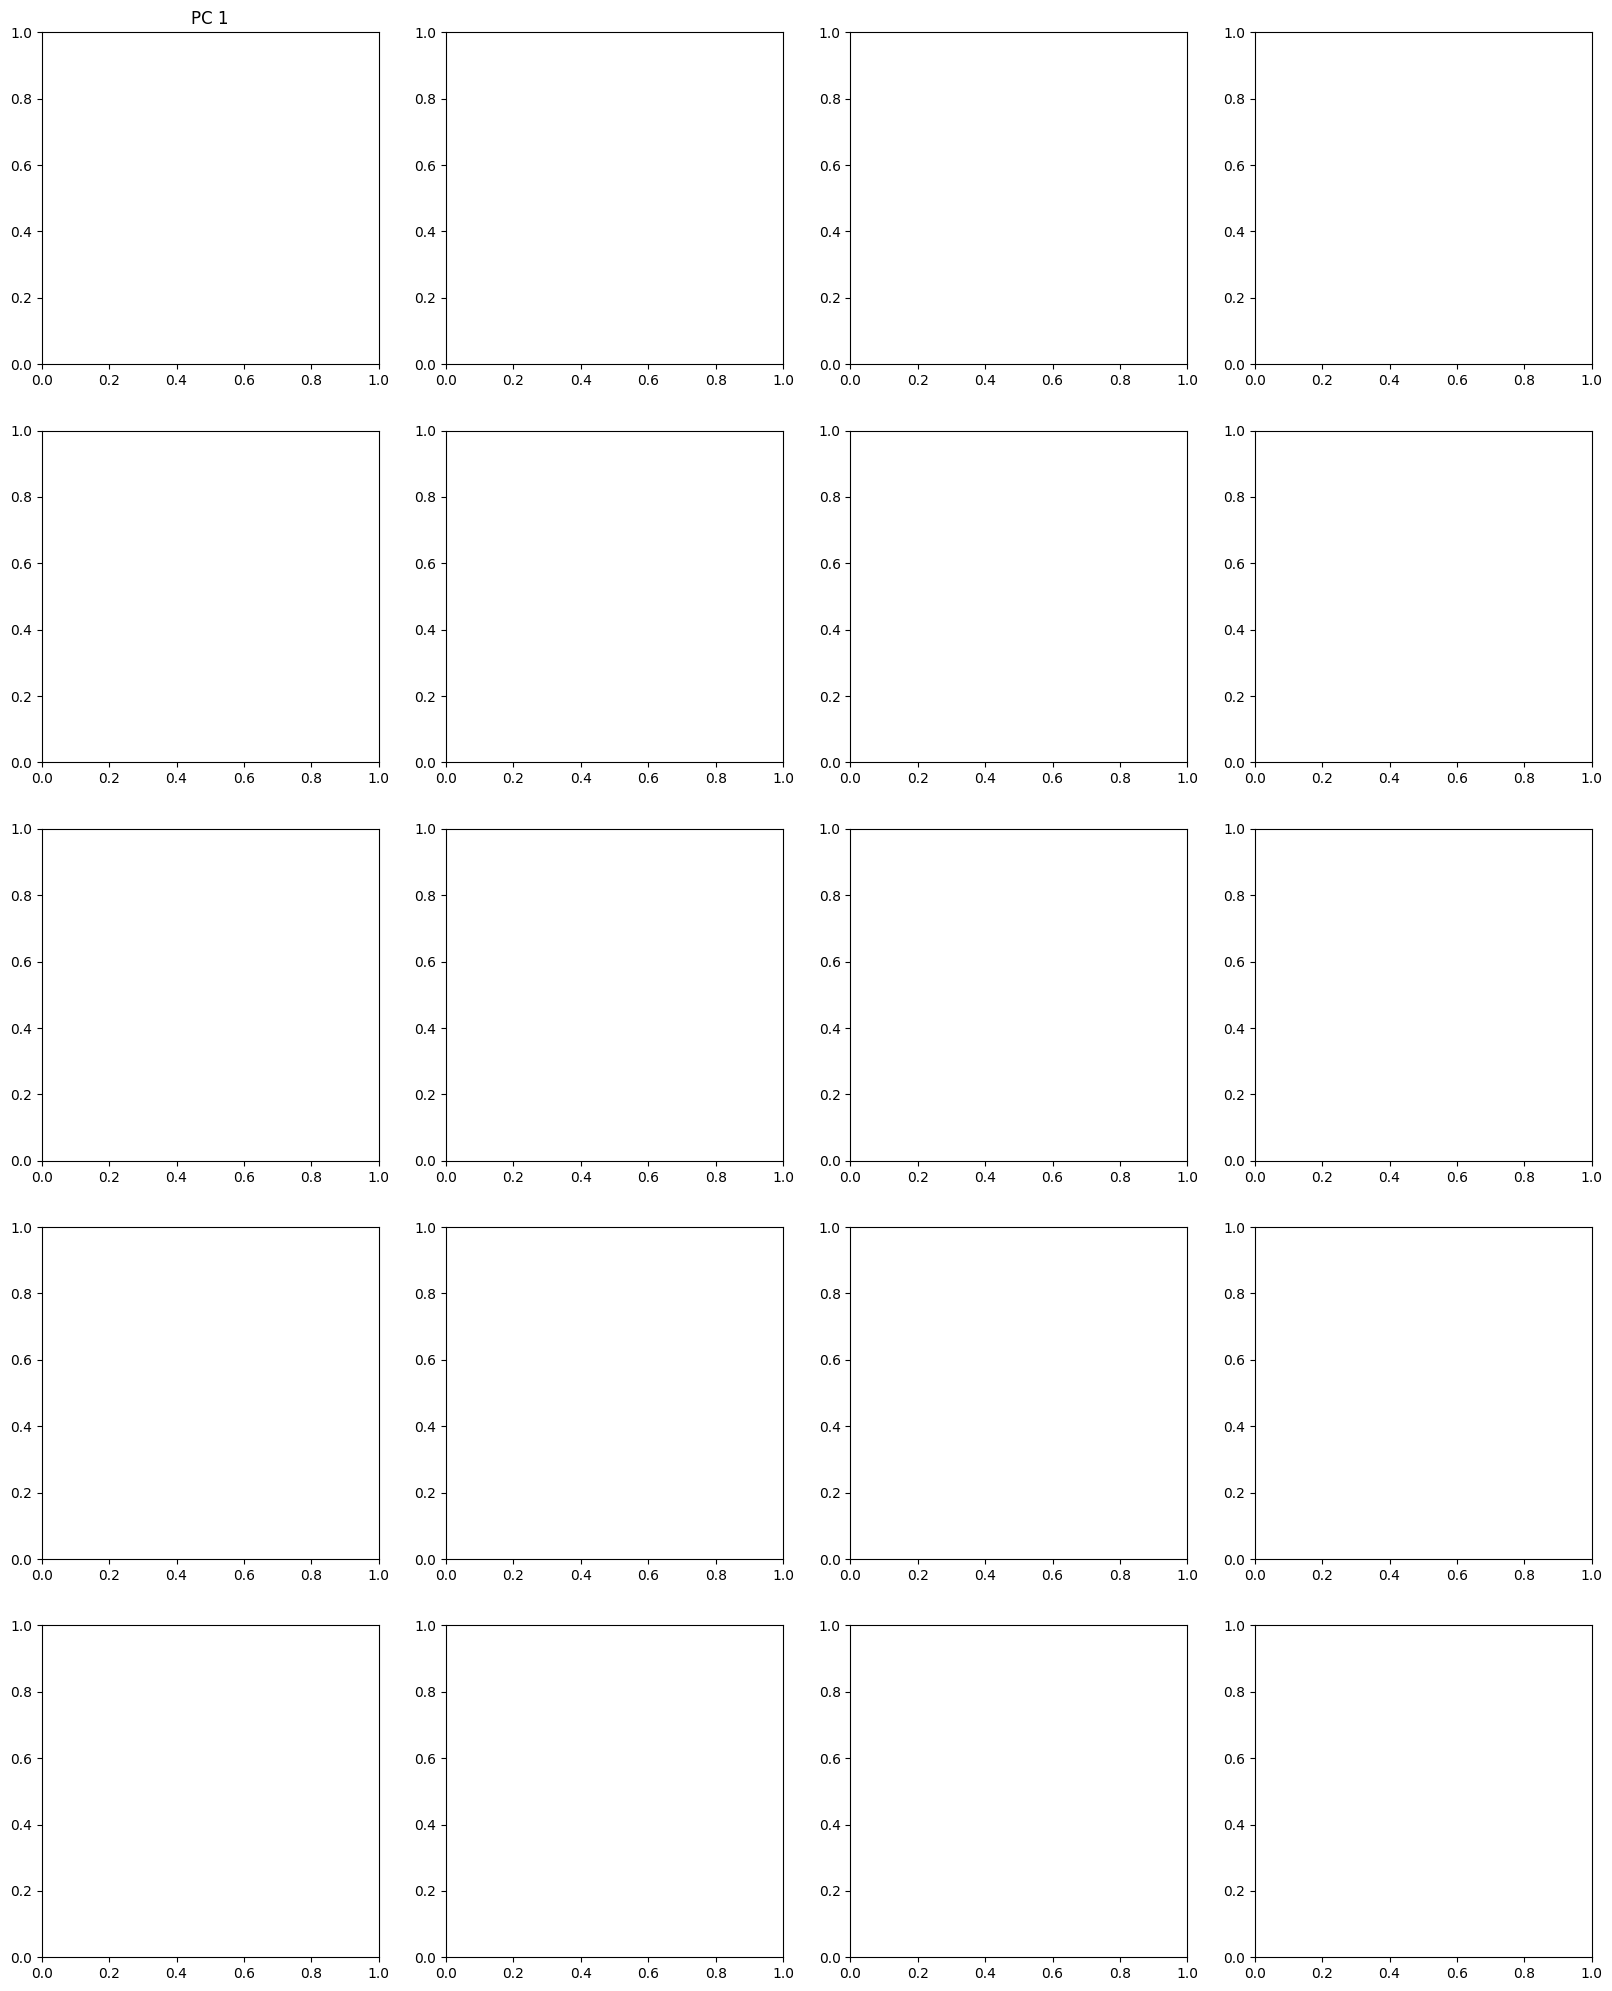

In [76]:
quartiles = np.linspace(0,100, num=5)
quartiles = list(zip(quartiles[:-1], quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0,1, num=len(quartiles)))
mean_waveform = np.mean(waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20,25))
ax = ax.flatten()
for pc_ix, pc in enumerate(pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " ")) # set the nice title
    scores = features_scores[pc].values # select the apropriate principal component from the dataframe
    q_maps = []
    for q_ix, (b,e) in enumerate(quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e)) # create a boolean map to select the waveforms
        q_mean = np.mean(waveforms[q_map], axis=0)
        ax[pc_ix].plot(waveform_times, q_mean/1e-15, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(waveform_times, mean_waveform/1e-15, lw=2, c="black", label="mean")
    #ax[pc_ix].set_ylim(-200,200)
ax[0].legend(fontsize=10)